<a href="https://colab.research.google.com/github/georgezefko/Recommender_System/blob/Matrix_approach/ABA_recommender_MF_11_05_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!pip install surprise

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
from scipy import linalg
from datetime import datetime
from surprise import Reader, Dataset, SVD, SVDpp, NMF, KNNBaseline,CoClustering,KNNBasic, KNNWithMeans,KNNWithZScore,SlopeOne,accuracy

from surprise.model_selection import cross_validate
from surprise.model_selection import KFold, GridSearchCV
from surprise import NormalPredictor
from surprise import BaselineOnly
from sklearn.linear_model import LinearRegression
from collections import defaultdict
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters


sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()


In [6]:
path = '/content/drive/MyDrive/AdvancedBA/Olie_data/'
#path ='/content/drive/MyDrive/olist_project/'
data = pd.read_csv(path+'recommender.csv')

#Further data pre-processing

In [7]:
data.head()

,Unnamed: 0,review_score,customer_state,seller_state,product_id,product_category_name_english,customer_unique_id,order_delivered_customer_date,price,delivered_date,days_diff,order_weekday,order_month,price_category,day_category
0,0,4,SP,SP,17106,housewares,45758,2017-10-10 21:25:13,29.99,2017-10-10,8.0,Monday,Oct,Low,morning
1,1,4,SP,SP,17106,housewares,21530,2017-08-18 14:44:43,29.99,2017-08-18,3.0,Tuesday,Aug,Low,afternoon
2,2,5,SP,SP,17106,housewares,87936,2017-08-07 18:30:01,29.99,2017-08-07,5.0,Wednesday,Aug,Low,afternoon
3,3,3,SC,SP,17106,housewares,85228,2017-11-07 18:04:59,29.99,2017-11-07,15.0,Monday,Oct,Low,evening
4,4,1,SP,SP,23951,housewares,44958,2017-08-28 20:12:20,46.80,2017-08-28,4.0,Thursday,Aug,Low,morning


In [8]:
# remove the excess column in the beginning
data = data.iloc[:,1:]

In [9]:
data.shape

(111686, 14)

In [10]:
data = data.loc[:,'product_category_name_english,customer_unique_id,product_id,review_score,order_weekday,order_month,day_category'.split(',')].drop_duplicates()

In [11]:
data.shape

(101101, 7)

In [12]:
data.head()

,product_category_name_english,customer_unique_id,product_id,review_score,order_weekday,order_month,day_category
0,housewares,45758,17106,4,Monday,Oct,morning
1,housewares,21530,17106,4,Tuesday,Aug,afternoon
2,housewares,87936,17106,5,Wednesday,Aug,afternoon
3,housewares,85228,17106,3,Monday,Oct,evening
4,housewares,44958,23951,1,Thursday,Aug,morning


In [13]:
#remove rating and users than have been given/gotten only one review
min_product_ratings = 1
filter_products = data['product_id'].value_counts() > min_product_ratings
filter_products = filter_products[filter_products].index.tolist()


min_user_ratings = 1
filter_users = data['customer_unique_id'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

data_new = data[(data['product_id'].isin(filter_products)) & (data['customer_unique_id'].isin(filter_users))]

In [14]:
len(data_new)

9760

In [15]:
data_new['combination'] = data_new['product_id'].apply(str) +' '+ data_new['product_category_name_english'] + ' ' + data_new['order_weekday']+ ' '+data_new['order_month']+ ' ' +data_new['day_category']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
data_new

,product_category_name_english,customer_unique_id,product_id,review_score,order_weekday,order_month,day_category,combination
0,housewares,45758,17106,4,Monday,Oct,morning,17106 housewares Monday Oct morning
50,housewares,54651,3315,4,Tuesday,Jan,evening,3315 housewares Tuesday Jan evening
54,housewares,18828,27150,1,Monday,Aug,evening,27150 housewares Monday Aug evening
95,housewares,18846,23621,1,Wednesday,Apr,evening,23621 housewares Wednesday Apr evening
134,housewares,79270,24487,5,Tuesday,Mar,afternoon,24487 housewares Tuesday Mar afternoon
...,...,...,...,...,...,...,...,...
111637,books_imported,48527,32053,5,Friday,Nov,evening,32053 books_imported Friday Nov evening
111647,books_imported,66013,13293,5,Monday,Jul,afternoon,13293 books_imported Monday Jul afternoon
111660,books_imported,46303,16592,4,Saturday,Apr,afternoon,16592 books_imported Saturday Apr afternoon
111676,la_cuisine,34041,26630,1,Wednesday,Nov,afternoon,26630 la_cuisine Wednesday Nov afternoon


In [17]:
data_new.shape

(9760, 8)

# Recommender algorithms


##Basic algorithms

**NormalPredictor**

NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. This is one of the most basic algorithms that do not do much work.

**BaselineOnly**

BaselineOnly algorithm predicts the baseline estimate for given user and item.

##k-NN algorithms
**KNNBasic**

KNNBasic is a basic collaborative filtering algorithm.

**KNNWithMeans**

KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.

**KNNWithZScore**

KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

**KNNBaseline**

KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.
##Matrix Factorization-based algorithms
**SVD**

SVD algorithm is equivalent to Probabilistic Matrix Factorization

**SVDpp**

The SVDpp algorithm is an extension of SVD that takes into account implicit ratings.

**NMF**

NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

**Slope One**

SlopeOne is a straightforward implementation of the SlopeOne algorithm.

**Co-clustering**

Coclustering is a collaborative filtering algorithm based on co-clustering.

In [18]:
ratings_df = data_new[['customer_unique_id','combination','review_score']]

In [19]:
ratings_df

,customer_unique_id,combination,review_score
0,45758,17106 housewares Monday Oct morning,4
50,54651,3315 housewares Tuesday Jan evening,4
54,18828,27150 housewares Monday Aug evening,1
95,18846,23621 housewares Wednesday Apr evening,1
134,79270,24487 housewares Tuesday Mar afternoon,5
...,...,...,...
111637,48527,32053 books_imported Friday Nov evening,5
111647,66013,13293 books_imported Monday Jul afternoon,5
111660,46303,16592 books_imported Saturday Apr afternoon,4
111676,34041,26630 la_cuisine Wednesday Nov afternoon,1


In [20]:
train_df, test_df = train_test_split(ratings_df, train_size=0.7, random_state = 0) # 2/3 -training 

In [21]:
# function to calculate the RMSE
def RMSE(y_true, y_pred):
    return np.linalg.norm(y_true - y_pred) / np.sqrt(len(y_true))

In [22]:
def performance(user,product,model):
  y_pred = []
  for user_id, product_id in zip(user, product):
    r = model.predict(user_id, product_id, verbose=False).est # predict ratings from user_id & product_id in test set
    y_pred.append(r)
  y_pred = np.array(y_pred)
  return y_pred

In [23]:
def recommendations(user,product,model):
  
  recommendations = []
  for product_id in  product:
    r = model.predict(user, product_id, verbose=False).est # predict ratings from user_id & product_id in test set
    recommendations.append((product_id,r))
   
  recommendations.sort(reverse=True, key=lambda x: x[1])

  return recommendations[:5]

In [24]:
reader = Reader(rating_scale=(1,5 ))
data_surprise = Dataset.load_from_df(train_df, reader)
#data_surprise = data_train_surprise.build_full_trainset()

In [ ]:
# chosen models
models = ['svd','svd++','nmfb','nmf','CoClustering','KNNBasic','KNNWithMeans','KNNWithZScore','KNNBaseline', 'BaselineOnly']

# values needed for predictions
y_true = test_df['review_score'].values 
user_ids_true = test_df['customer_unique_id'].values
product_ids_true = test_df['combination'].values



for i in models:
  if i == 'svd':
    param_grid = {'n_factors': [70, 80, 90, 100, 110, 120, 130, 140, 150, 160], 
                  'n_epochs': [100], 
                  'reg_all': [0.1]}
    gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3) # cross validation 3-folds
    gs_svd.fit(data_surprise)
    best_svd = gs_svd.best_score['rmse']
    best_svd_params = gs_svd.best_params['rmse']
    model_svd = gs_svd.best_estimator['rmse']
    model_svd.fit(data_surprise.build_full_trainset())
    y_pred_svd = performance(user_ids_true,product_ids_true,model_svd)
    error_svd = RMSE(y_true, y_pred_svd)
  
  elif i == 'svd++':
    param_grid = {'lr_all': [0.001, 0.003, 0.005, 0.007, 0.009], 
                  'reg_all': [0.005, 0.01, 0.015, 0.02, 0.025]}
    gs_svdpp = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=3)
    gs_svdpp.fit(data_surprise)
    best_svd_plus = gs_svdpp.best_score['rmse']
    best_svd_plus_params = gs_svdpp.best_params['rmse']
    model_svd_plus = gs_svdpp.best_estimator['rmse']
    model_svd_plus.fit(data_surprise.build_full_trainset())
    y_pred_svd_plus = performance(user_ids_true,product_ids_true,model_svd_plus)
    error_svd_plus = RMSE(y_true, y_pred_svd_plus)


  elif i == 'nmfb':
    param_grid = {'n_factors': [1,2,3,4,5,6,7,8,9,10], 
                  'n_epochs': [100], 
                  'biased': [True], 
                  'reg_bu': [0.1], 
                  'reg_bi': [0.1]}
    gs_nmfb = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=3)
    gs_nmfb.fit(data_surprise)
    best_nmfb = gs_nmfb.best_score['rmse']
    best_nmfb_params = gs_nmfb.best_params['rmse']
    model_nmfb = gs_nmfb.best_estimator['rmse']
    model_nmfb.fit(data_surprise.build_full_trainset())
    y_pred_nmfb = performance(user_ids_true,product_ids_true,model_nmfb)
    error_nmfb = RMSE(y_true, y_pred_nmfb)

  elif i == 'nmf':
    param_grid = {'n_factors': [200, 220, 240], 
                  'n_epochs': [100]}
    gs_nmf = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=3)
    gs_nmf.fit(data_surprise)
    best_nmf = gs_nmf.best_score['rmse']
    best_nmf_params = gs_nmf.best_params['rmse']
    model_nmf = gs_nmf.best_estimator['rmse']
    model_nmf.fit(data_surprise.build_full_trainset())
    y_pred_nmf = performance(user_ids_true,product_ids_true,model_nmf)
    error_nmf = RMSE(y_true, y_pred_nmf)

  elif i == 'CoClustering':
    param_grid = {'n_cltr_u': [3,4,5], 
                  'n_cltr_i': [3,4,5],'n_epochs':[20,100]}
    gs_CoClustering = GridSearchCV(CoClustering, param_grid, measures=['rmse'], cv=3)
    gs_CoClustering.fit(data_surprise)
    best_CoClustering = gs_CoClustering.best_score['rmse']
    best_CoClustering_params = gs_CoClustering.best_params['rmse']
    model_CoClustering = gs_CoClustering.best_estimator['rmse']
    model_CoClustering.fit(data_surprise.build_full_trainset())
    y_pred_CoClustering = performance(user_ids_true,product_ids_true,model_CoClustering)
    error_CoClustering = RMSE(y_true, y_pred_CoClustering)
    
  elif i == 'KNNBasic':
    param_grid = {'k': [40, 50, 60], 'sim_options': {'user_based': [True, False]}}
    gs_KNNBasic = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)
    gs_KNNBasic.fit(data_surprise)
    best_KNNBasic = gs_KNNBasic.best_score['rmse']
    best_KNNBasic_params = gs_KNNBasic.best_params['rmse']
    model_KNNBasic = gs_KNNBasic.best_estimator['rmse']
    model_KNNBasic.fit(data_surprise.build_full_trainset())
    y_pred_KNNBasic = performance(user_ids_true,product_ids_true,model_KNNBasic)
    error_KNNBasic = RMSE(y_true, y_pred_KNNBasic)

  elif i == 'KNNWithMeans':
    param_grid = {'k': [40, 50, 60], 'sim_options': {'user_based': [True, False]}}
    gs_KNNWithMeans = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=3)
    gs_KNNWithMeans.fit(data_surprise)
    best_KNNWithMeans = gs_KNNWithMeans.best_score['rmse']
    best_KNNWithMeans_params = gs_KNNWithMeans.best_params['rmse']
    model_KNNWithMeans = gs_KNNWithMeans.best_estimator['rmse']
    model_KNNWithMeans.fit(data_surprise.build_full_trainset())
    y_pred_KNNWithMeans = performance(user_ids_true,product_ids_true,model_KNNWithMeans)
    error_KNNWithMeans = RMSE(y_true, y_pred_KNNWithMeans)

  elif i == 'KNNWithZScore':
    param_grid = {'k': [40, 50, 60], 'sim_options': {'user_based': [True, False]}}
    gs_KNNWithZScore = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse'], cv=3)
    gs_KNNWithZScore.fit(data_surprise)
    best_KNNWithZScore = gs_KNNWithZScore.best_score['rmse']
    best_KNNWithZScore_params = gs_KNNWithZScore.best_params['rmse']
    model_KNNWithZScore = gs_KNNWithZScore.best_estimator['rmse']
    model_KNNWithZScore.fit(data_surprise.build_full_trainset())
    y_pred_KNNWithZScore = performance(user_ids_true,product_ids_true,model_KNNWithZScore)
    error_KNNWithZScore = RMSE(y_true, y_pred_KNNWithZScore)

  elif i == 'KNNBaseline':
    param_grid = {'k': [40, 50, 60], 'sim_options': {'user_based': [True, False]},
              'bsl_options': {'method': ['als', 'sgd']}}
    gs_KNNBaseline = GridSearchCV(KNNBaseline, param_grid, measures=['rmse'], cv=3)
    gs_KNNBaseline.fit(data_surprise)
    best_KNNBaseline = gs_KNNBaseline.best_score['rmse']
    best_KNNBaseline_params = gs_KNNBaseline.best_params['rmse']
    model_KNNBaseline = gs_KNNBaseline.best_estimator['rmse']
    model_KNNBaseline.fit(data_surprise.build_full_trainset())
    y_pred_KNNBaseline = performance(user_ids_true,product_ids_true,model_KNNBaseline)
    error_KNNBaseline = RMSE(y_true, y_pred_KNNBaseline)

  elif i == 'BaselineOnly':
    param_grid = {'bsl_options': {'method': ['als', 'sgd']}
               }
    gs_Baseline = GridSearchCV(BaselineOnly, param_grid, measures=['rmse'], cv=3)
    gs_Baseline.fit(data_surprise)
    best_Baseline = gs_Baseline.best_score['rmse']
    best_Baseline_params = gs_Baseline.best_params['rmse']
    model_Baseline = gs_Baseline.best_estimator['rmse']
    model_Baseline.fit(data_surprise.build_full_trainset())
    y_pred_Baseline = performance(user_ids_true,product_ids_true,model_Baseline)
    error_Baseline = RMSE(y_true, y_pred_Baseline)

    #for normal predictor i get error on param_grid, maybe needs other parameters

  # elif i=='NormalPredictor':
  #   param_grid = {'bsl_options': {'method': ['als', 'sgd']}
  #              }
  #   gs_Normal = GridSearchCV(NormalPredictor, param_grid, measures=['rmse'], cv=3)
  #   gs_Normal.fit(data_surprise)
  #   best_Normal = gs_Normal.best_score['rmse']
  #   best_Normal_params = gs_Normal.best_params['rmse']
  #   model_Normal = gs_Normal.best_estimator['rmse']
  #   model_Normal.fit(data_surprise.build_full_trainset())
  #   y_pred_Normal = performance(user_ids_true,product_ids_true,model_Normal)
  #   error_Normal = RMSE(y_true, y_pred_Normal)



  
  







# Results summary

In [26]:


print(f'The best Baseline score: {best_Baseline}\nThe best Baseline parameters are: {best_Baseline_params}')
print(80*'-')
# print(f'The best NormalPredictos score: {best_Normal}\nThe best Baseline parameters are: {best_Normal_params}')
# print(80*'-')
print(f'The best SVD score: {best_svd}\nThe best SVD parameters are: {best_svd_params}')
print(80*'-')
print(f'The best SVD++ score: {best_svd_plus}\nThe best SVD++ parameters are: {best_svd_plus_params}')
print(80*'-')
print(f'The best Biased NMF score: {best_nmfb}\nThe best Biased NMF parameters are: {best_nmfb_params}')
print(80*'-')
print(f'The best NMF score: {best_nmf}\nThe best NMF parameters are: {best_nmf_params}')
print(80*'-')
print(f'The best CoClustering score: {best_CoClustering}\nThe best CoClustering parameters are: {best_CoClustering_params}')
print(80*'-')
print(f'The best KNNBasic score: {best_KNNBasic}\nThe best KNNBasic parameters are: {best_KNNBasic_params}')
print(80*'-')
print(f'The best KNNWithMeans score: {best_KNNWithMeans}\nThe best KNNWithMeans parameters are: {best_KNNWithMeans_params}')
print(80*'-')
print(f'The best KNNWithZScore score: {best_KNNWithZScore}\nThe best KNNWithZScore parameters are: {best_KNNWithZScore_params}')
print(80*'-')
print(f'The best KNNBaseline score: {best_KNNBaseline}\nThe best KNNBaseline parameters are: {best_KNNBaseline_params}')
print(80*'-')



The best Baseline score: 1.5124415283322399
The best Baseline parameters are: {'bsl_options': {'method': 'sgd'}}
--------------------------------------------------------------------------------
The best SVD score: 1.4640010780161443
The best SVD parameters are: {'n_factors': 70, 'n_epochs': 100, 'reg_all': 0.1}
--------------------------------------------------------------------------------
The best SVD++ score: 1.4907184147103962
The best SVD++ parameters are: {'lr_all': 0.009, 'reg_all': 0.015}
--------------------------------------------------------------------------------
The best Biased NMF score: 1.4827093901289619
The best Biased NMF parameters are: {'n_factors': 1, 'n_epochs': 100, 'biased': True, 'reg_bu': 0.1, 'reg_bi': 0.1}
--------------------------------------------------------------------------------
The best NMF score: 1.5862935304907866
The best NMF parameters are: {'n_factors': 220, 'n_epochs': 100}
----------------------------------------------------------------------

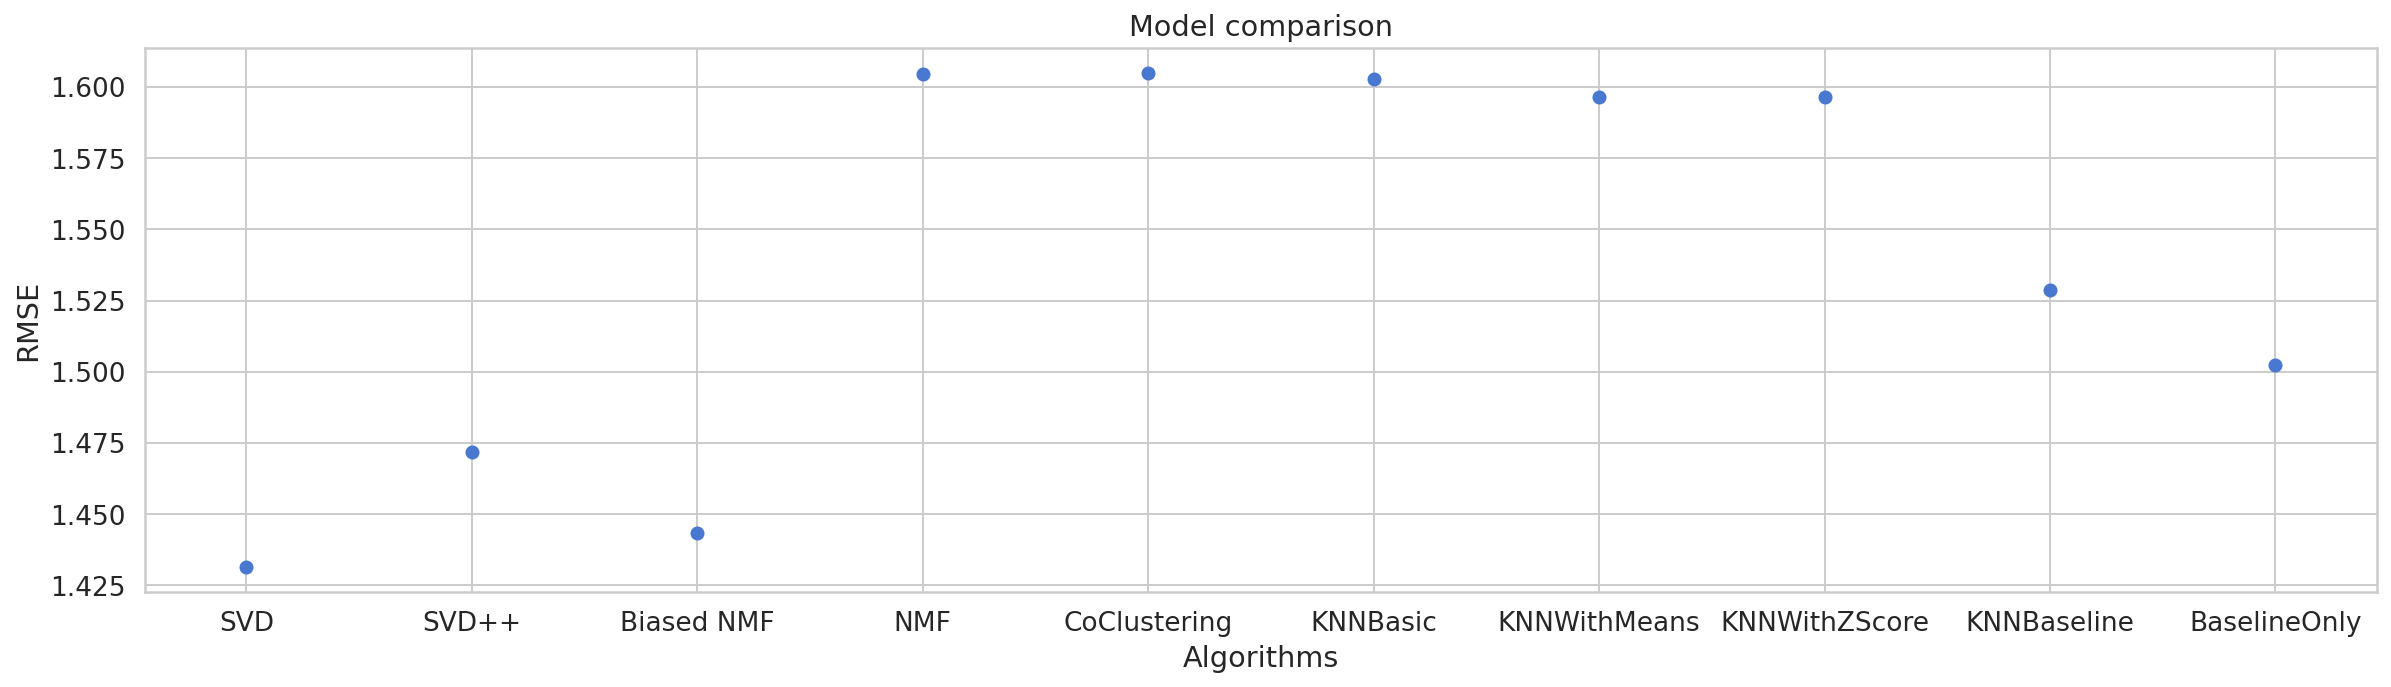

In [27]:
import matplotlib.pyplot as plt
RMSEs = [error_svd, error_svd_plus, error_nmfb, error_nmf, error_CoClustering,error_KNNBasic,error_KNNWithMeans,error_KNNWithZScore,error_KNNBaseline,error_Baseline]
algorithms = ['SVD', 'SVD++', "Biased NMF", 'NMF', 'CoClustering','KNNBasic','KNNWithMeans','KNNWithZScore','KNNBaseline', 'BaselineOnly']

plt.figure(figsize=(20,5))
plt.plot(algorithms, RMSEs,'bo' )
plt.xlabel("Algorithms")
plt.ylabel("RMSE")
plt.title('Model comparison')
plt.show()


## Recommendations

In [28]:
recommendations(34041,product_ids_true,model_svd)

[('23159 computers_accessories Wednesday May evening', 3.356469191266185),
 ('20472 food_drink Saturday Aug afternoon', 3.3272109116374207),
 ('20244 bed_bath_table Monday Feb evening', 3.224067404310936),
 ('27433 furniture_bedroom Thursday Jan afternoon', 3.21850530973548),
 ('31032 auto Tuesday Feb evening', 3.207297835965201)]

#Visualizing the Similarity Between products

In [108]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
reduction=True

if reduction:
  pca = PCA(n_components=2)
  products = pca.fit_transform(model_svd.qi)
else:
  tsne = TSNE(n_components=2, perplexity=15,n_iter=500, verbose=3, random_state=1)
  products = tsne.fit_transform(model_svd.qi)



projection = pd.DataFrame(columns=['x', 'y'], data=products)
projection['title'] = train_df['combination']

Text(0, 0.5, 'y')

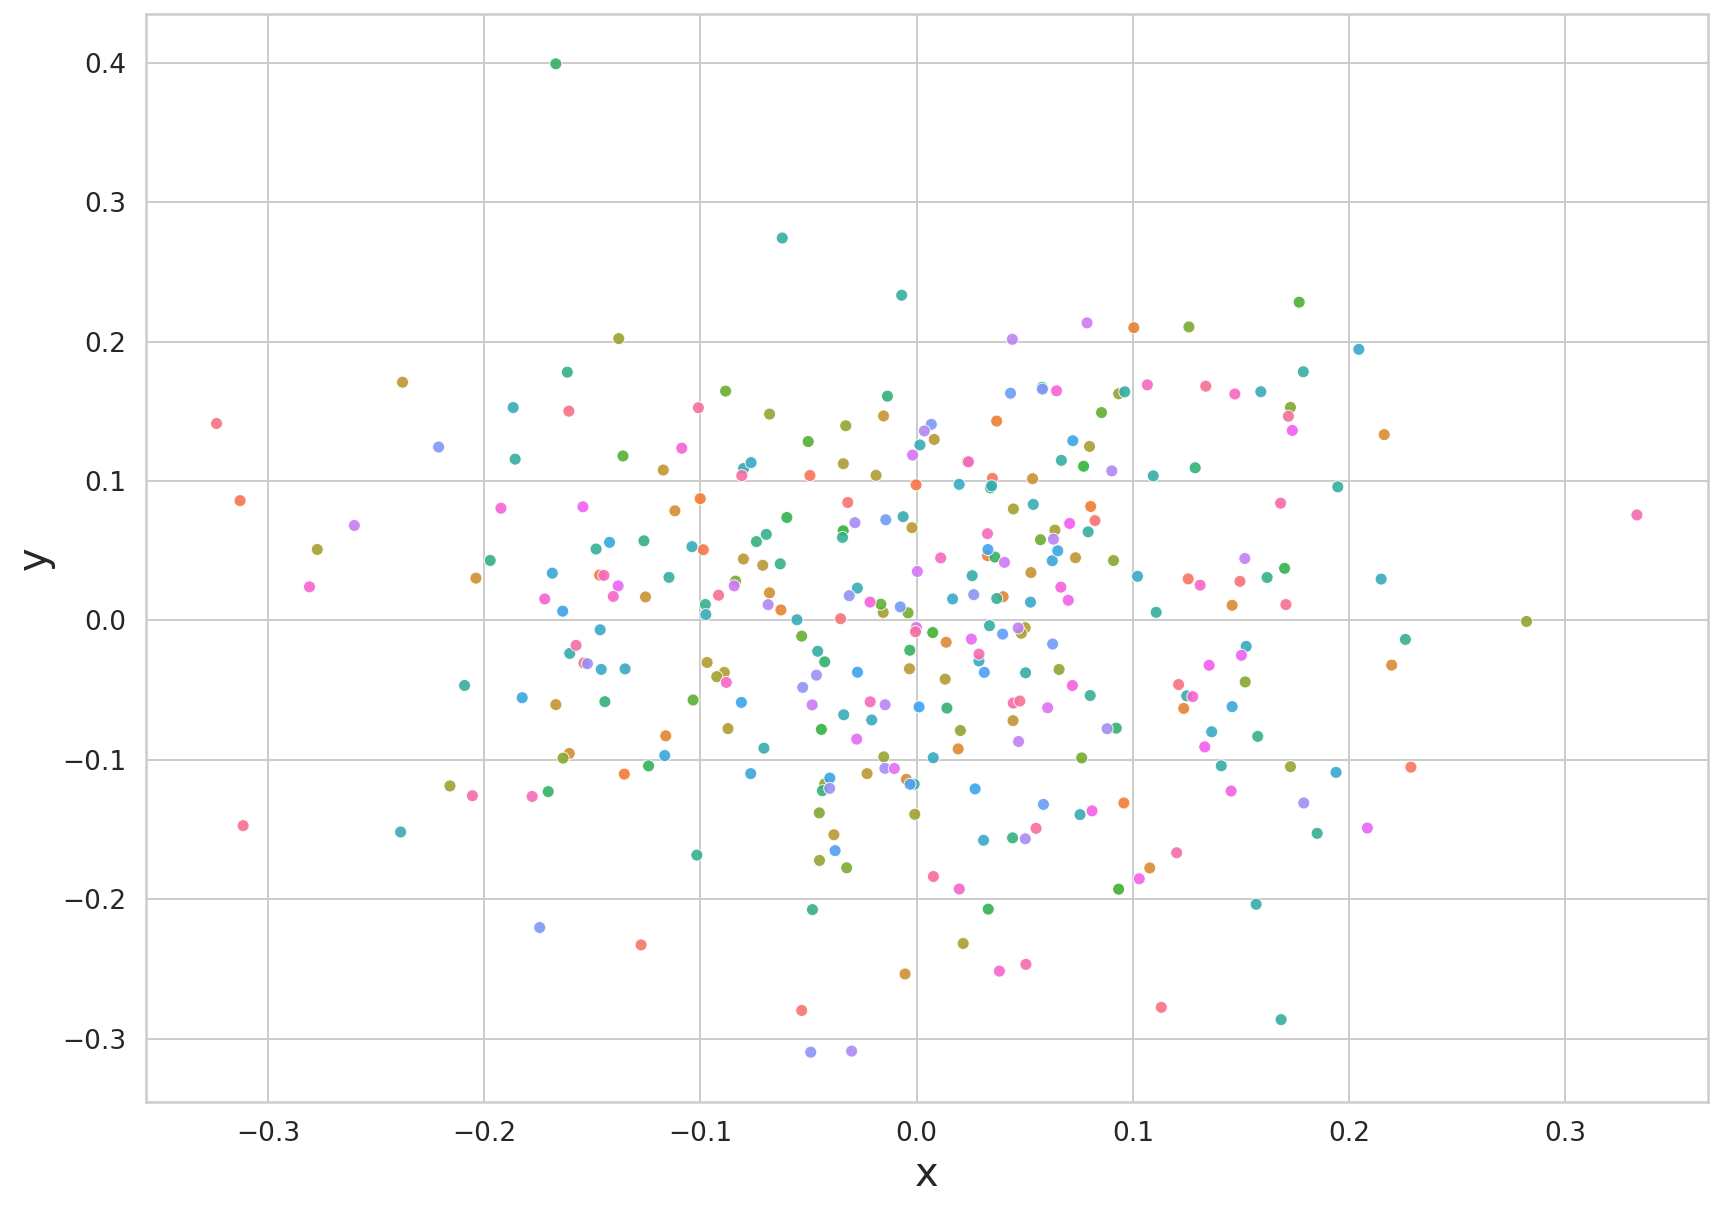

In [109]:
b = sns.scatterplot(
    x='x', y='y',hue='title',
    
    legend=False,
    data=projection,
    alpha=0.9)
b.set_xlabel('x',fontsize=20)
b.set_ylabel('y',fontsize=20)



Based on the plot produced above, we can see that the points representing the 6000 products seem to follow a two-dimensional normal distribution. 


### next step try to plot the vectors

In [89]:
project = projection.dropna()

In [65]:
x=projection.iloc[:,0].values


0.011896646388195133

In [93]:
plt.rc('figure', max_open_warning = 0)
labels = project['title'].values
x = projection.iloc[:0].values
y=projection.iloc[:1].values



plt.figure(figsize=(15, 15)) 
for i in range(10):
  plt.scatter(x[i],y[i])
  plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
plt.show()

IndexError: ignored

<Figure size 1080x1080 with 0 Axes>

# The approaches below probably are not necessary

#Item-Item Collaborative filtering

In [ ]:
user = ratings_df.drop_duplicates(['customer_unique_id'])
item = user.pivot_table(values='review_score', index='customer_unique_id',columns='combination',fill_value=0)

In [ ]:
item

In [ ]:
correlations = item.transpose().corr()
correlations

In [ ]:
K = 5
user_id = 580

In [ ]:
neighbours_corr = correlations[user_id].sort_values(ascending=False)[1: K+1]
neighbours_corr

In [ ]:
neighbours_ratings = item.loc[neighbours_corr.index]
neighbours_ratings

In [ ]:
# Find a list of missing ratings for the user
missing_ratings = item.loc[user_id]
missing_ratings = missing_ratings[missing_ratings.isnull()]
missing_ratings

In [ ]:
# make predictions
user_mean = item.loc[user_id].mean()
neighbours_means = neighbours_ratings.mean(axis=1)
for movie_name, val in missing_ratings.iteritems():
    rating = 0
    weights_sum = 0
    for neighbour_id, row in neighbours_ratings.iterrows():
        if np.isnan(row[movie_name]): continue
        rating += neighbours_corr.loc[neighbour_id] * (row[movie_name] - neighbours_means.loc[neighbour_id])
        weights_sum += abs(neighbours_corr.loc[neighbour_id])
    if weights_sum > 0:
        rating /= weights_sum
    rating += user_mean
    missing_ratings.at[movie_name] = rating
missing_ratings.sort_values(ascending=False)[0:5]

## Item-Item


In [ ]:
correlations = item.corr()

In [ ]:
for movie_name, val in missing_ratings.iteritems():
    rating = 0
    weights_sum = 0
    neighbours_corr = correlations[movie_name].sort_values(ascending=False)[1: K+1]
    item_mean = item[movie_name].mean()
    neighbours_ratings = item[neighbours_corr.index].transpose()
    neighbours_means = neighbours_ratings.mean(axis=1)
    for neighbour_id, row in neighbours_ratings.iterrows():
        if np.isnan(row[user_id]): continue
        rating += neighbours_corr[neighbour_id] * (row[user_id] - neighbours_means[neighbour_id])
        weights_sum += abs(neighbours_corr[neighbour_id])
    if weights_sum > 0:
        rating /= weights_sum
    rating += item_mean
    missing_ratings.at[movie_name] = rating
missing_ratings.sort_values(ascending=False)[0:5]

# Content based recommender system


In [ ]:
data_new['combination'] = data_new['product_id'].apply(str) +' '+ data_new['product_category_name_english'] + ' ' + data_new['order_weekday']+ ' '+data_new['seller_state']+' '+data_new['order_month']+ ' ' +data_new['day_category']+' '+data_new['price_category']

In [ ]:
item_df = data_new[['customer_unique_id','combination']]

In [ ]:
item_df['combination'] = item_df['combination'].str.lower()

In [ ]:
item_df.head(10)

In [ ]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(item_df['combination'])

In [ ]:
count_matrix.shape

In [ ]:
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [ ]:
metadata = item_df.reset_index()
#indices = pd.Series(metadata.index, index=metadata['title'])
metadata

In [ ]:
indices = pd.Series(metadata.index, index=metadata['customer_unique_id']).drop_duplicates()


In [ ]:
def get_recommendations(customer, cosine_sim=cosine_sim2):
    idx = indices[customer]
    print(idx.iloc[0])

    sim_scores = list(enumerate(cosine_sim[idx.iloc[0]]))
    print(sim_scores)

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    
    sim_scores = sim_scores[1:11]

    
    customer_indices = [i[0] for i in sim_scores]
    scores = [ i[1] for i in sim_scores]

    
    sim_products = metadata['combination'].iloc[customer_indices]
    sim_customers = metadata['customer_unique_id'].iloc[customer_indices]
    rec = {'customer': sim_customers, 'product': sim_products,'score':scores}
    return pd.DataFrame(data=rec)

In [ ]:
get_recommendations(34041, cosine_sim=cosine_sim2)